#  Deconvolution by KanCell on melanoma dataset

In [ ]:
import sys
sys.path.append('/data/wzh/KanCell-main')

In [4]:
import pandas as pd
import scanpy as sc
import anndata
import os
from tqdm import tqdm 
import scanpy as sc
import numpy as np
import sys

## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in ``.obs``.

In [5]:
adata = sc.read('/data/KanCell-main/docs/data/melanoma/Spatial.h5ad')
scadata = sc.read_h5ad('/data/KanCell-main/docs/data/melanoma/scRNA.h5ad')
scadata.var_names_make_unique()
scadata.obs_names_make_unique()

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Initialize and train the KanCell_l model

In this step, we initialize the KanCell_l model using anndata objects for scRNA-seq and ST as input. The``celltype_key`` parameter represents the column name of the cell type annotation in the .obs attribute of the scRNA-seq anndata object. The ``sm_size`` parameter controls the number of simulated spots, and it is important to have a sufficient ``sm_size`` for accurate prediction. However, it should be noted that increasing the ``sm_size`` will also increase the simulation and training time. In general, we recommend setting ``sm_size`` to a value greater than 100,000.

In [13]:
import KanCell
from KanCell import KanCell_l
from Kancell.setting import set_environ_seed
set_environ_seed()


Setting environment seed: 42


Global seed set to 0


In [14]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
KanCell_l_model = KanCell_l.init_model(scadata,adata,celltype_key='CellType',sm_size=500000,use_gpu=True,n_threads=16)

Setting global seed: 42
### Finding marker genes...
CellType
TYPE_B cells              200
TYPE_CD4 T cells          200
TYPE_CD8 T cells          200
TYPE_Endothelial cells    200
TYPE_Fibroblasts          200
TYPE_Macrophages          200
TYPE_Melanoma cells       200
TYPE_NK cells             200
Name: count, dtype: int64
### Used gene numbers: 1408
### Initializing sample probability
### Genetating simulated spatial data using scRNA data with mode: unbalance
### Genetating simulated spatial data using scRNA data with mode: sqrt
### Genetating simulated spatial data using scRNA data with mode: balance


In [15]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
KanCell_l_model.train(max_steps=5000, batch_size=1024)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/100:   1%|          | 1/100 [00:09<15:44,  9.55s/it, loss=1.38e+03, v_num=1]

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [14:48<00:00,  8.91s/it, loss=1.21e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [14:48<00:00,  8.88s/it, loss=1.21e+03, v_num=1]


Step 5000: Test inference loss=-0.975: 100%|██████████| 5000/5000 [25:45<00:00,  3.23it/s]


Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a DataFrame object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the .obs attribute.

In [16]:
pre = KanCell_l_model.deconv_spatial()
st_ad = KanCell_l_model.st_ad
# st_ad.write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

## Visualization results

As a demonstration, we plotted the predicted compositions of cell types on a slice, where the cell types are selected as the top 20 with the highest proportion within each spot.

In [17]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(4,4))
sc.settings.verbosity = 3

In [19]:
pre = KanCell_l_model.deconv_spatial()
celltype = st_ad.obs.loc[:,pre.columns].max(0)
st_ad = KanCell_l_model.st_ad

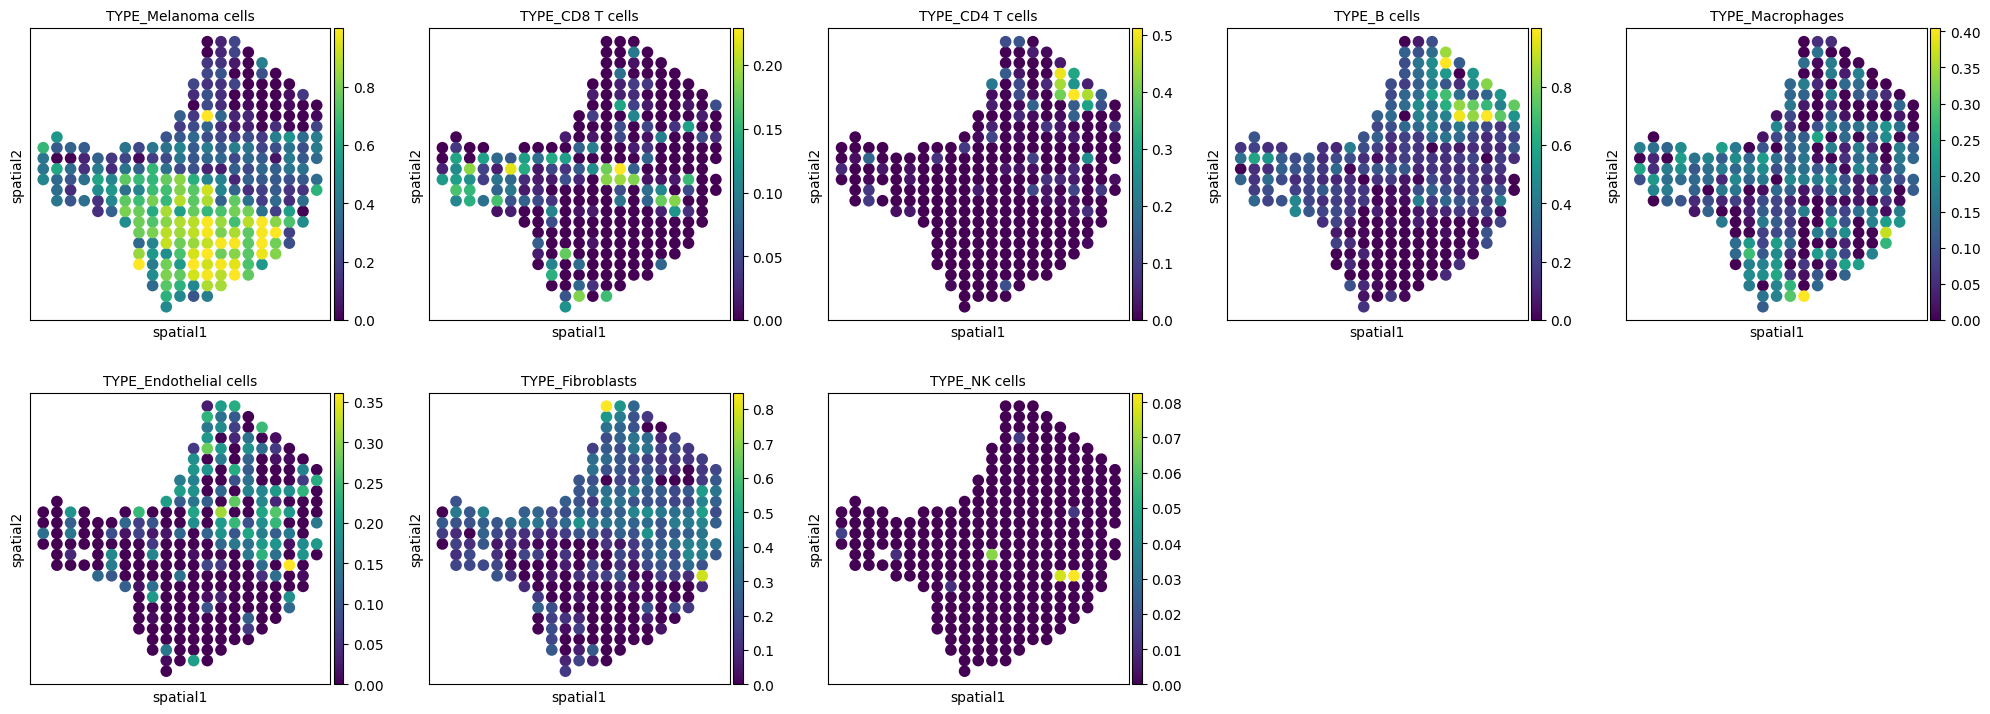

In [21]:
sc.pl.embedding(st_ad,color=pre.columns[:20],basis='spatial',ncols=5,s=280)

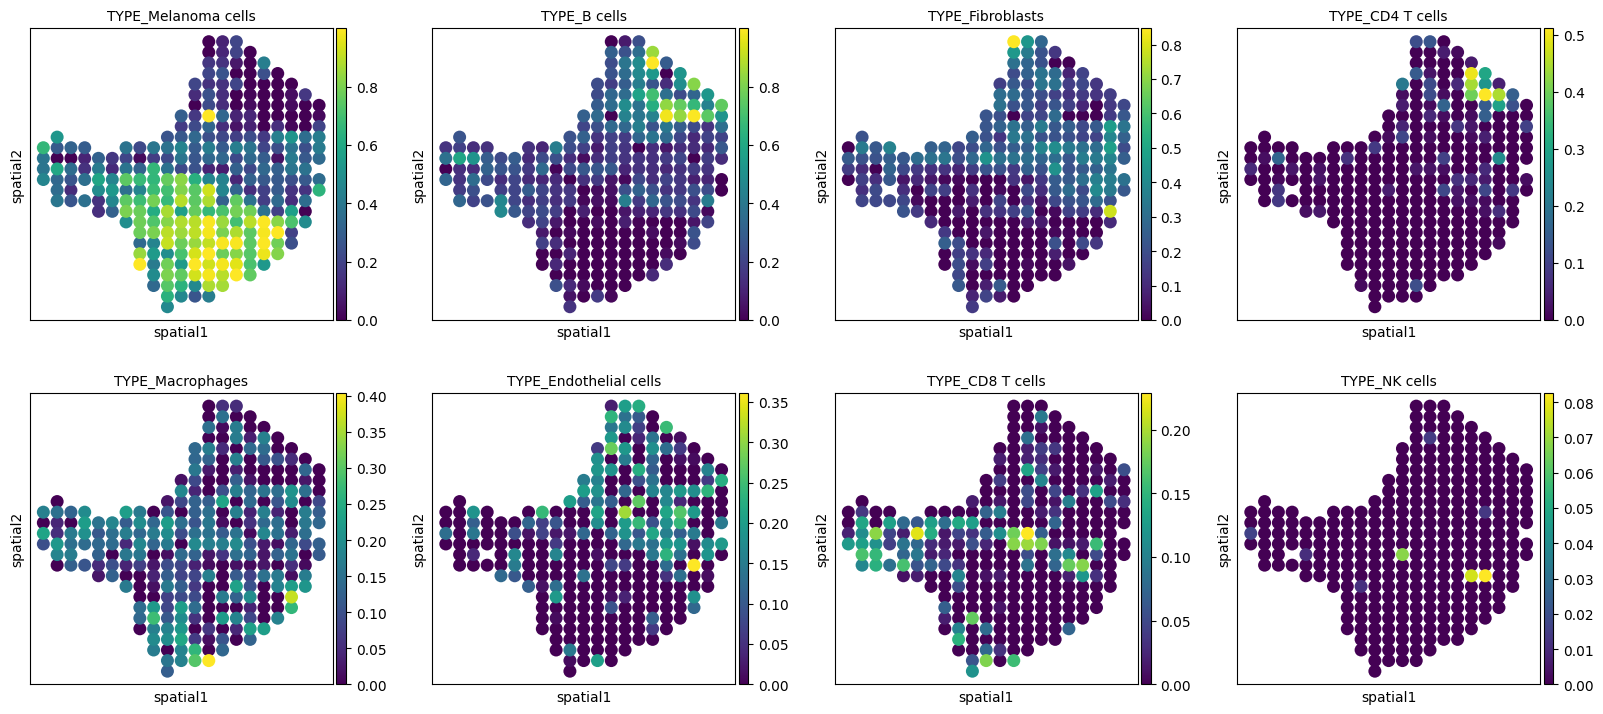

<Figure size 200x200 with 0 Axes>

In [22]:
import scanpy as sc
import matplotlib.pyplot as plt


# 假设 st_ad 是已经加载好的 AnnData 对象，并且 celltype 是您感兴趣的细胞类型列
# 更新字体大小
plt.rcParams.update({'font.size': 14})  # 设置全局字体大小
# 绘制embedding图
sc.pl.embedding(st_ad, color=celltype.sort_values(ascending=False)[:20].index, basis='spatial', ncols=4,s=350, size=10)
# 调整每个子图的字体大小
fig = plt.gcf()
axes = fig.get_axes()
for ax in axes:
    ax.title.set_size(30)  # 设置标题字体大小
    ax.xaxis.label.set_size(20)  # 设置x轴标签字体大小
    ax.yaxis.label.set_size(16)  # 设置y轴标签字体大小
    ax.tick_params(axis='both', which='major', labelsize=11)  # 设置刻度字体大小
# 显示图形
plt.show()



Tumor Region Summary Statistics
          n_genes  TYPE_Melanoma cells  TYPE_CD8 T cells  TYPE_CD4 T cells  \
count  102.000000           102.000000        102.000000        102.000000   
mean   200.509804             0.794498          0.011425          0.002244   
std     75.252281             0.133568          0.025756          0.014201   
min      1.000000             0.517048          0.000000          0.000000   
25%    151.250000             0.708467          0.000000          0.000000   
50%    196.000000             0.786241          0.000000          0.000000   
75%    253.750000             0.896136          0.000000          0.000000   
max    422.000000             0.999992          0.110211          0.121373   

       TYPE_B cells  TYPE_Macrophages  TYPE_Endothelial cells  \
count    102.000000        102.000000              102.000000   
mean       0.050732          0.086166                0.014208   
std        0.070794          0.080288                0.040180   
min  

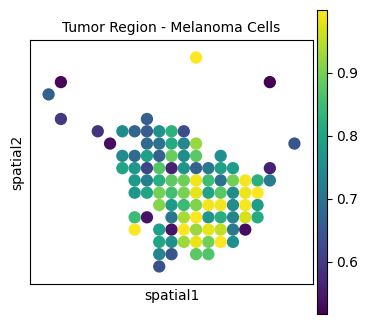

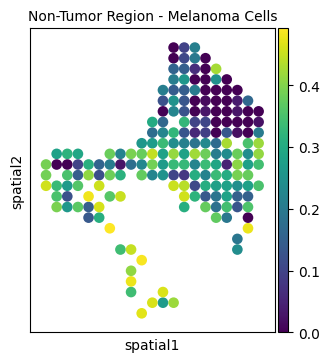

In [47]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 加载AnnData对象

adata = st_ad

# 识别肿瘤和非肿瘤区域（根据'TYPE_Melanoma cells'的表达值）
tumor_cells = adata.obs['TYPE_Melanoma cells'] > 0.5
non_tumor_cells = adata.obs['TYPE_Melanoma cells'] <= 0.5

# 提取肿瘤和非肿瘤区域的数据
tumor_data = adata[tumor_cells]
non_tumor_data = adata[non_tumor_cells]

# 汇总统计肿瘤和非肿瘤区域的数据
tumor_summary = tumor_data.obs.describe()
non_tumor_summary = non_tumor_data.obs.describe()

print("Tumor Region Summary Statistics")
print(tumor_summary)

print("Non-Tumor Region Summary Statistics")
print(non_tumor_summary)

# 设置图像大小
figsize = (4, 4)  # 可以根据需要调整图像大小

# 绘制空间分布图，需要提供spot_size参数，并进行y轴翻转
spot_size = 1.0  # 可以根据需要调整spot_size的大小

# 翻转y轴以匹配提供的图片方向
fig, ax = plt.subplots(figsize=figsize)
sc.pl.spatial(tumor_data, color='TYPE_Melanoma cells', title='Tumor Region - Melanoma Cells', spot_size=spot_size, ax=ax, show=False)
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=figsize)
sc.pl.spatial(non_tumor_data, color='TYPE_Melanoma cells', title='Non-Tumor Region - Melanoma Cells', spot_size=spot_size, ax=ax, show=False)
ax.invert_yaxis()
plt.show()

# 保存统计结果为CSV文件
tumor_summary.to_csv("tumor_summary.csv")
non_tumor_summary.to_csv("non_tumor_summary.csv")


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


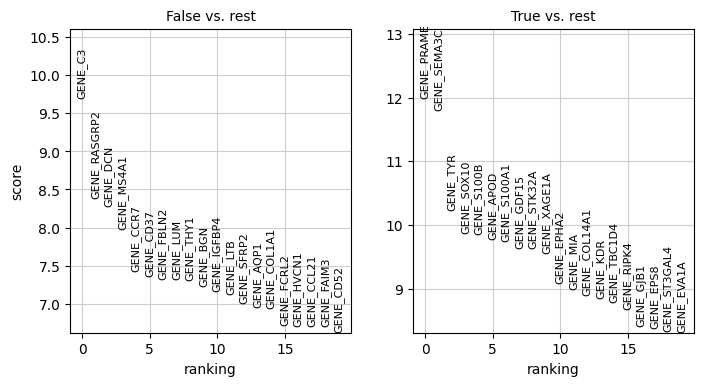

Tumor DE Genes: ['PRAME', 'SEMA3C', 'TYR', 'SOX10', 'S100B', 'APOD', 'S100A1', 'GDF15', 'STK32A', 'XAGE1A']
Non-Tumor DE Genes: ['C3', 'RASGRP2', 'DCN', 'MS4A1', 'CCR7', 'CD37', 'FBLN2', 'LUM', 'THY1', 'BGN']


In [65]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 假设 st_ad 是已经加载好的 AnnData 对象，并且 celltype 是您感兴趣的细胞类型列
adata = st_ad

# 计算高变基因
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

# 筛选高变基因
adata = adata[:, adata.var.highly_variable]

# 归一化和对数转换
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 识别肿瘤和非肿瘤区域
adata.obs['tumor'] = (adata.obs['TYPE_Melanoma cells'] > 0.5).astype('category')

# 差异表达分析
sc.tl.rank_genes_groups(adata, 'tumor', method='t-test')

# 可视化差异表达基因
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
plt.rcParams.update({'font.size': 14})
plt.show()

# 提取肿瘤区域显著差异表达基因并去除前缀
tumor_de_genes = adata.uns['rank_genes_groups']['names']['True']
tumor_de_genes = [gene.replace('GENE_', '') for gene in tumor_de_genes if gene is not None]

# 提取非肿瘤区域显著差异表达基因并去除前缀
non_tumor_de_genes = adata.uns['rank_genes_groups']['names']['False']
non_tumor_de_genes = [gene.replace('GENE_', '') for gene in non_tumor_de_genes if gene is not None]

# 打印前10个基因名称，确保格式正确
print("Tumor DE Genes:", tumor_de_genes[:10])
print("Non-Tumor DE Genes:", non_tumor_de_genes[:10])


          Gene_set                               Term Overlap       P-value  \
0  KEGG_2021_Human         Hematopoietic cell lineage   52/99  8.479338e-34   
1  KEGG_2021_Human            Cell adhesion molecules  54/148  3.477206e-25   
2  KEGG_2021_Human   Th1 and Th2 cell differentiation   38/92  2.475552e-20   
3  KEGG_2021_Human                      Leishmaniasis   34/77  1.878085e-19   
4  KEGG_2021_Human           Type I diabetes mellitus   24/43  3.959261e-17   
5  KEGG_2021_Human    Staphylococcus aureus infection   35/95  5.884980e-17   
6  KEGG_2021_Human  B cell receptor signaling pathway   32/81  1.165922e-16   
7  KEGG_2021_Human                Allograft rejection   22/38  2.818848e-16   
8  KEGG_2021_Human          Graft-versus-host disease   23/42  3.192627e-16   
9  KEGG_2021_Human          Th17 cell differentiation  36/107  6.098609e-16   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.416611e-31            0                     0   15.

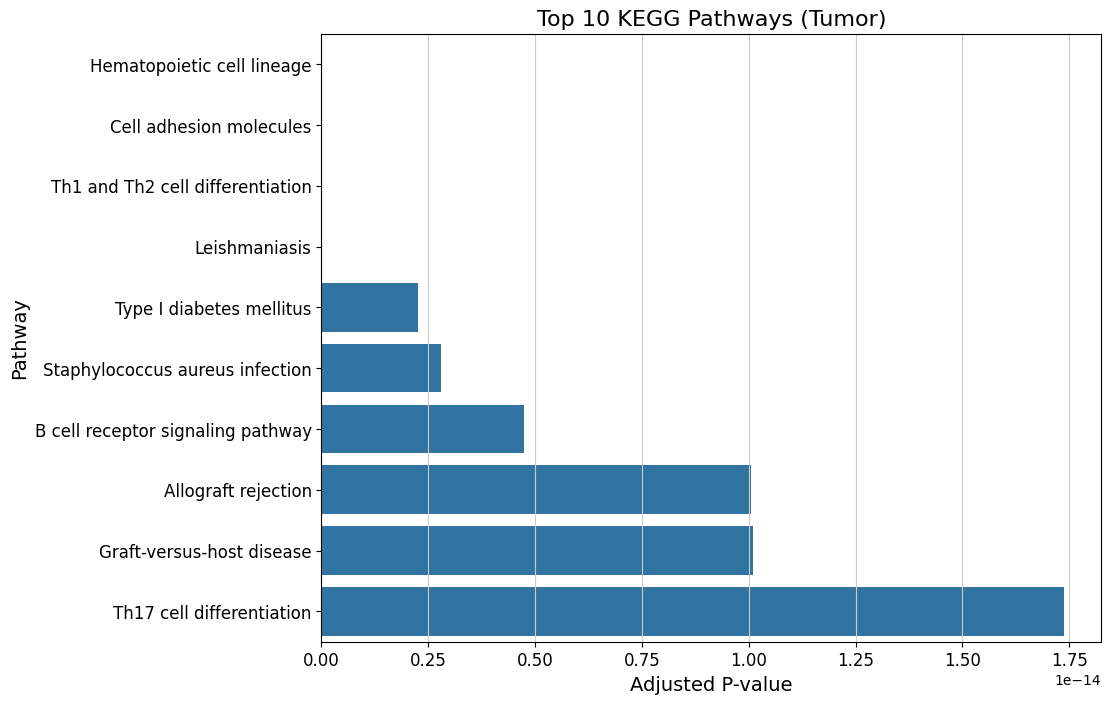

In [66]:
import gseapy as gp
import seaborn as sns

# 使用gseapy进行KEGG通路富集分析（肿瘤区域）
tumor_enr = gp.enrichr(gene_list=tumor_de_genes, gene_sets='KEGG_2021_Human', outdir=None)

# 确认富集分析结果（肿瘤区域）
print(tumor_enr.results.head(10))  # 打印前10个富集分析结果

# 可视化前10个显著的KEGG通路（肿瘤区域）
if not tumor_enr.results.empty:
    tumor_enr_results = tumor_enr.results.head(10)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Adjusted P-value', y='Term', data=tumor_enr_results)
    plt.title('Top 10 KEGG Pathways (Tumor)', fontsize=16)
    plt.xlabel('Adjusted P-value', fontsize=14)
    plt.ylabel('Pathway', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
else:
    print("没有显著的KEGG通路（肿瘤区域）")


          Gene_set                               Term Overlap       P-value  \
0  KEGG_2021_Human         Hematopoietic cell lineage   52/99  8.479338e-34   
1  KEGG_2021_Human            Cell adhesion molecules  54/148  3.477206e-25   
2  KEGG_2021_Human   Th1 and Th2 cell differentiation   38/92  2.475552e-20   
3  KEGG_2021_Human                      Leishmaniasis   34/77  1.878085e-19   
4  KEGG_2021_Human           Type I diabetes mellitus   24/43  3.959261e-17   
5  KEGG_2021_Human    Staphylococcus aureus infection   35/95  5.884980e-17   
6  KEGG_2021_Human  B cell receptor signaling pathway   32/81  1.165922e-16   
7  KEGG_2021_Human                Allograft rejection   22/38  2.818848e-16   
8  KEGG_2021_Human          Graft-versus-host disease   23/42  3.192627e-16   
9  KEGG_2021_Human          Th17 cell differentiation  36/107  6.098609e-16   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.416611e-31            0                     0   15.

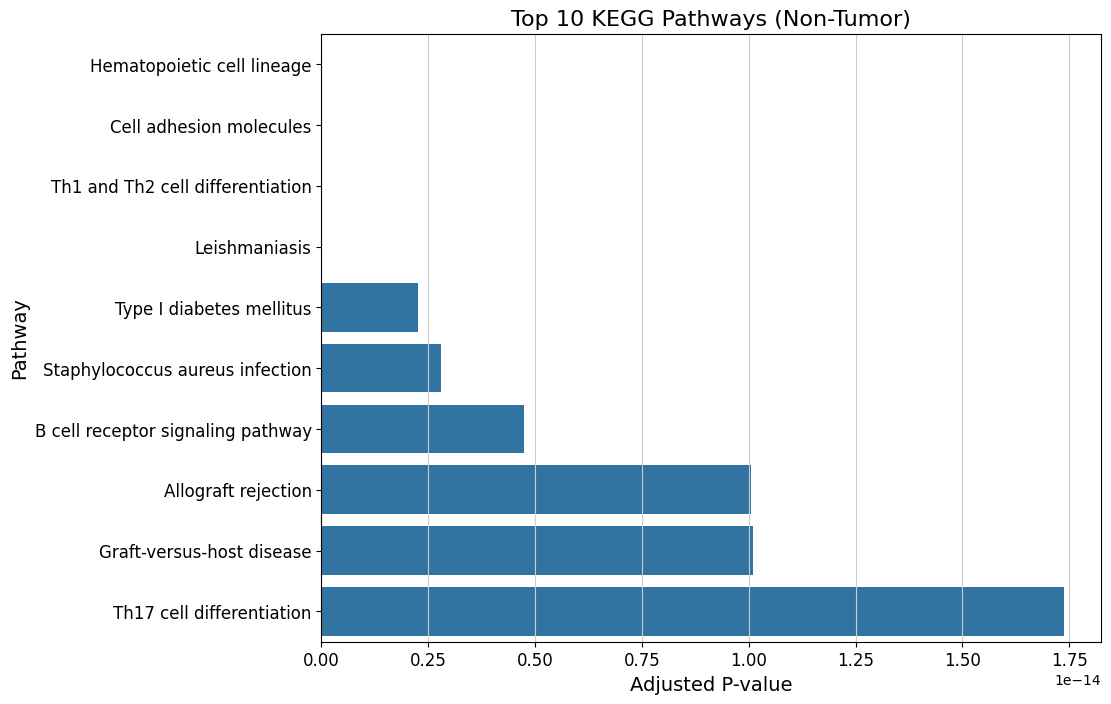

In [67]:
# 使用gseapy进行KEGG通路富集分析（非肿瘤区域）
non_tumor_enr = gp.enrichr(gene_list=non_tumor_de_genes, gene_sets='KEGG_2021_Human', outdir=None)

# 确认富集分析结果（非肿瘤区域）
print(non_tumor_enr.results.head(10))  # 打印前10个富集分析结果

# 可视化前10个显著的KEGG通路（非肿瘤区域）
if not non_tumor_enr.results.empty:
    non_tumor_enr_results = non_tumor_enr.results.head(10)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Adjusted P-value', y='Term', data=non_tumor_enr_results)
    plt.title('Top 10 KEGG Pathways (Non-Tumor)', fontsize=16)
    plt.xlabel('Adjusted P-value', fontsize=14)
    plt.ylabel('Pathway', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
else:
    print("没有显著的KEGG通路（非肿瘤区域）")


In [240]:
import scanpy as sc

# 确认已加载的 AnnData 对象
adata = st_ad

# 识别肿瘤和非肿瘤区域
adata.obs['tumor'] = (adata.obs['TYPE_Melanoma cells'] > 0.5).astype('category')

print(adata.obs['tumor'].value_counts())


tumor
False    191
True     102
Name: count, dtype: int64


In [161]:
# 计算高变基因
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

# 筛选高变基因
adata = adata[:, adata.var.highly_variable]

# 确认高变基因筛选结果
print(adata.var.highly_variable.value_counts())


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
highly_variable
True    1408
Name: count, dtype: int64


In [162]:
# 归一化和对数转换
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 计算高变基因后的统计信息
print(adata.X.shape)


normalizing counts per cell
    finished (0:00:00)
(293, 1408)


In [163]:
# 差异表达分析
sc.tl.rank_genes_groups(adata, 'tumor', method='t-test')

# 检查差异表达分析结果
print(adata.uns['rank_genes_groups'].keys())
print(adata.uns['rank_genes_groups']['names'].dtype)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
(numpy.record, [('False', 'O'), ('True', 'O')])


In [169]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 提取肿瘤区域显著差异表达基因
de_results_tumor = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['True'],
    'logfoldchange': adata.uns['rank_genes_groups']['logfoldchanges']['True'],
    'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj']['True'],
    'group': 'Tumor'
})

# 提取非肿瘤区域显著差异表达基因
de_results_non_tumor = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['False'],
    'logfoldchange': adata.uns['rank_genes_groups']['logfoldchanges']['False'],
    'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj']['False'],
    'group': 'Non-Tumor'
})

# 合并数据，确保每个基因只保留一个组中的记录
de_results_combined = pd.concat([de_results_tumor, de_results_non_tumor])
de_results_combined = de_results_combined.sort_values(by='pvals_adj').drop_duplicates(subset='gene', keep='first')




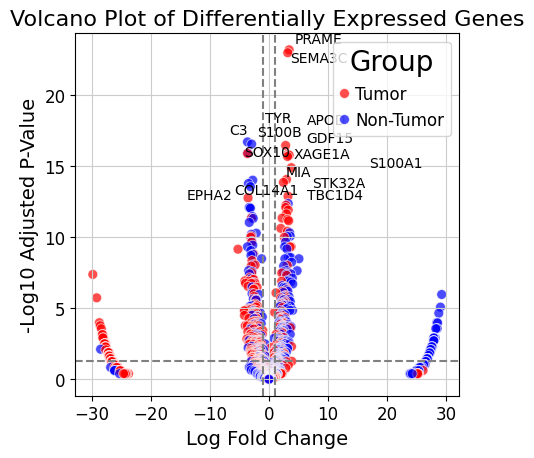

In [237]:
from adjustText import adjust_text
# 合并数据，确保每个基因只保留一个组中的记录
de_results_combined = pd.concat([de_results_tumor, de_results_non_tumor])
de_results_combined = de_results_combined.sort_values(by='pvals_adj').drop_duplicates(subset='gene', keep='first')

# 绘制火山图
plt.figure(figsize=(5, 5))  # 缩小图片尺寸
sns.scatterplot(data=de_results_combined, x='logfoldchange', y=-np.log10(de_results_combined['pvals_adj']),
                hue='group', palette={'Tumor': 'red', 'Non-Tumor': 'blue'}, alpha=0.7, s=50)  # 增大点的大小
plt.xlabel('Log Fold Change', fontsize=14)  # 增大字体
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)  # 增大字体
plt.title('Volcano Plot of Differentially Expressed Genes', fontsize=16)  # 增大标题字体
plt.axhline(-np.log10(0.05), color='gray', linestyle='--')
plt.axvline(1, color='gray', linestyle='--')
plt.axvline(-1, color='gray', linestyle='--')
plt.legend(title='Group', fontsize=12)  # 增大图例字体
plt.xticks(fontsize=12)  # 增大刻度字体
plt.yticks(fontsize=12)  # 增大刻度字体

# 标记显著基因的前15个
top_genes = de_results_combined.sort_values(by='pvals_adj').head(15)
texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['logfoldchange'], -np.log10(row['pvals_adj']), row['gene'], fontsize=10))

# 自动调整文本位置，避免重叠
adjust_text(texts)

plt.tight_layout()
plt.show()

filtered out 14 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:39)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:

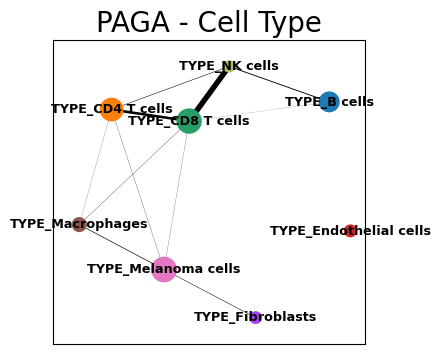

In [238]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import matplotlib.pyplot as plt

# 假设 scadata 是已经加载的 AnnData 对象
adata = scadata.copy()

# 计算总计数和线粒体基因比例
adata.obs['total_counts'] = adata.X.sum(axis=1)
adata.obs['pct_counts_mt'] = (adata[:, adata.var_names.str.startswith('MT-')].X.sum(axis=1) / adata.obs['total_counts']) * 100

# 数据预处理
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# PCA分析
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# 运行 PAGA
sc.tl.paga(adata, groups='CellType')

# 绘制 CellType 的 PAGA 图
fig, ax = plt.subplots(figsize=(4, 4))  # 调整图形尺寸
sc.pl.paga(adata, color='CellType', title='PAGA - Cell Type', ax=ax, show=False)
plt.title('PAGA - Cell Type', fontsize=20)  # 增大标题字体
ax.tick_params(axis='both', which='major', labelsize=16)  # 增大刻度字体
plt.savefig('paga_celltype.png')
plt.show()


computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


dpt_pseudotime has been added to adata.obs


<Figure size 500x400 with 0 Axes>

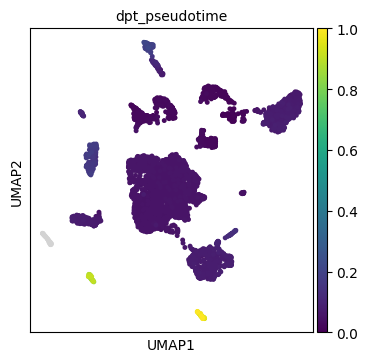

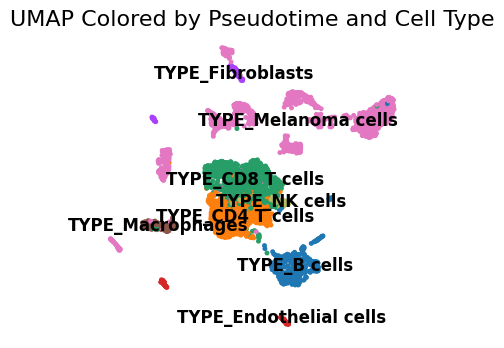

In [194]:
import scanpy as sc
import matplotlib.pyplot as plt

# 确保已经加载了必要的数据和模块
# 假设adata已经加载并包含所需的obs列

# 选择 TYPE_Melanoma cells 作为起点细胞类型
root_cells = adata[adata.obs['CellType'] == 'TYPE_Melanoma cells']
if root_cells.shape[0] > 0:
    root_cell_index = root_cells.obs.index[0]
    root_cell_pos = adata.obs.index.get_loc(root_cell_index)
    adata.uns['iroot'] = root_cell_pos

    # 进行伪时间分析
    sc.tl.dpt(adata, n_dcs=10)

    # 检查 dpt_pseudotime 是否在 adata.obs 中
    if 'dpt_pseudotime' in adata.obs:
        print("dpt_pseudotime has been added to adata.obs")
    else:
        print("dpt_pseudotime not found in adata.obs")
else:
    print("No TYPE_Melanoma cells found in the dataset.")

# 绘制 UMAP 图并根据伪时间对细胞进行颜色编码，同时使用形状区分不同的细胞类型
plt.figure(figsize=(10, 8))
sc.pl.umap(adata, color='dpt_pseudotime', size=50, show=False)
sc.pl.umap(adata, color='CellType', frameon=False, size=50, legend_loc='on data', legend_fontsize=12, show=False)
plt.title('UMAP Colored by Pseudotime and Cell Type', fontsize=16)
plt.show()
